In [1]:
from gptopt.optim.attn_kq import *
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Regularization of primal
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + \frac{\mu}{2}(\|Z_1\|_F^2 + \|Z_2\|_F^2)  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2,
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \frac{1}{1 + \mu\gamma}\left (\begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right ) \right )
\end{aligned}
$$




## FISTA for dual solve

$$
\begin{array}{ll}
{\text{maximize}} &  
-\frac{1}{2\mu}\|\mathcal{A}^*(Y) + G\|_F^2 - h^*(Y)
\end{array}  
$$
recover primal using
$$
Z = -\frac{1}{\mu}(\mathcal{A}^*(Y) + G)
$$

$$
\begin{aligned}
Y^{t+1} &= \mathbf{prox}_{\frac{1}{\alpha} h^*}\left (\tilde Y^t - \frac{1}{\alpha} \mathcal{A}(\mathcal{A}^*(\tilde Y^t) + G)\right )\\
\tilde Y^{t+1} &= Y^{t+1} + \frac{k-1}{k+2} ( Y^{t+1} -  Y^t)
\end{aligned}
$$

# Smooth relaxation of primal problem
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G, Z \rangle + \frac{1}{2\mu }\|(|\mathcal{A}(Z)| - \beta)_+\|_F^2
\end{array}  
$$

## Nesterov for primal problem
$$
\begin{align}
\nabla f(U^k) &= G + \frac{1}{\mu} \mathcal{A}^*\left (\mathcal{A}(U^k) 
- \Pi_{[-\beta, \beta]}(\mathcal{A}(U^k))\right ) \\
Z^{k+1} &= U^k - \frac{\mu}{{\|\mathcal{A}\|_{\operatorname{op}}^2}} \nabla f(U^k) \\
U^{k+1} &= Z^{k+1} + \frac{k-1}{k+2} (Z^{k+1} - Z^k)
\end{align}
$$

In [3]:
n_layer = 4
std1 = 1 #0.02 / np.sqrt(2.0 * n_layer)
std2 = 1 #0.01
rank_ratio = 0.7
max_iter = 100

mu_scales = [0.1, 0.001]
mu_moreau_scales = [1, 0.1, 0.001]
beta = 0.01

In [4]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

#  $m=n=50$

In [5]:
m = n = 50
std2 = 1  
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, rank_ratio=1,
                                                                 G_in_range=True)


mu_max = (G1.t() @ B + A.t() @ G2).abs().max().item() / beta
nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5 

print(f"{lamb_max=:.4e}, {mu_max=:.4e}")

lamb_max=7.0456e+01, mu_max=1.1639e+03


In [6]:
Z_star_1, Z_star_2, f_star, Y_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta, verbose=False)

In [7]:
func_obj = lambda Z1, Z2: (torch.trace(G1.T @ Z1) + torch.trace(G2.T @ Z2)).item()  
func_constr_viol = lambda Z1, Z2: max(torch.max(torch.abs(Z1.T @ B + A.T @ Z2)).item() - beta, 0) / beta

In [8]:
assert np.allclose(f_star, func_obj(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2)), rtol=1e-5)
print(
    f"{f_star=:.4e}" 
    f"\ncvxpy constraint violation: "
    f"{func_constr_viol(torch.from_numpy(Z_star_1).to(G1), torch.from_numpy(Z_star_2).to(G2))}"
)
print(pd_residuals_infty_ball(A=A, B=B, Y=torch.from_numpy(Y_star).to(G1.dtype).to(G1.device), 
                              Z1=torch.from_numpy(Z_star_1).to(G1.dtype).to(G1.device), 
                              Z2=torch.from_numpy(Z_star_2).to(G1.dtype).to(G1.device), 
                                      G1=G1, G2=G2, beta=beta, mu=0))

f_star=-5.0323e-01
cvxpy constraint violation: 9.089708328038903e-07
(9.176212188322097e-08, 1.8352424376644195e-07, 1.471410121501623e-06, 1.1566718986134993e-07)


In [9]:
residuals = {}
for mu_scale in mu_scales:
    for mu_mor_scale in mu_moreau_scales:
        mu_reg = max(mu_scale * mu_max, 1e-6)
        print(f"{mu_reg=:.4e}, {mu_scale=:.4e}, {mu_mor_scale=:.4e}")
        mu_moreau = max(mu_mor_scale * mu_reg, 1e-6)
        residuals[(mu_scale, mu_mor_scale)] = compare_methods_fista_nesterov(A, B, G1, G2, beta, mu_reg=mu_reg, mu_moreau=mu_moreau,
                                stopping=False, max_iter=max_iter)

mu_reg=1.1639e+02, mu_scale=1.0000e-01, mu_mor_scale=1.0000e+00
Method                 Obj          Viol
----------------------------------------
fista         -4.390882e-01  3.745013e-02
nesterov G init  -1.834585e+02  1.148443e+03
nesterov rand init  -1.834585e+02  1.148442e+03
nesterov zero init  -1.834584e+02  1.148442e+03
mu_reg=1.1639e+02, mu_scale=1.0000e-01, mu_mor_scale=1.0000e-01
Method                 Obj          Viol
----------------------------------------
fista         -4.390882e-01  3.745013e-02
nesterov G init  -1.879044e+01  1.144634e+02
nesterov rand init  -1.879036e+01  1.144607e+02
nesterov zero init  -1.879038e+01  1.144631e+02
mu_reg=1.1639e+02, mu_scale=1.0000e-01, mu_mor_scale=1.0000e-03
Method                 Obj          Viol
----------------------------------------
fista         -4.390882e-01  3.745013e-02
nesterov G init  -6.619016e-01  1.146230e+00
nesterov rand init  -6.606081e-01  1.081196e+00
nesterov zero init  -6.613040e-01  1.133849e+00
mu_reg=1.1639

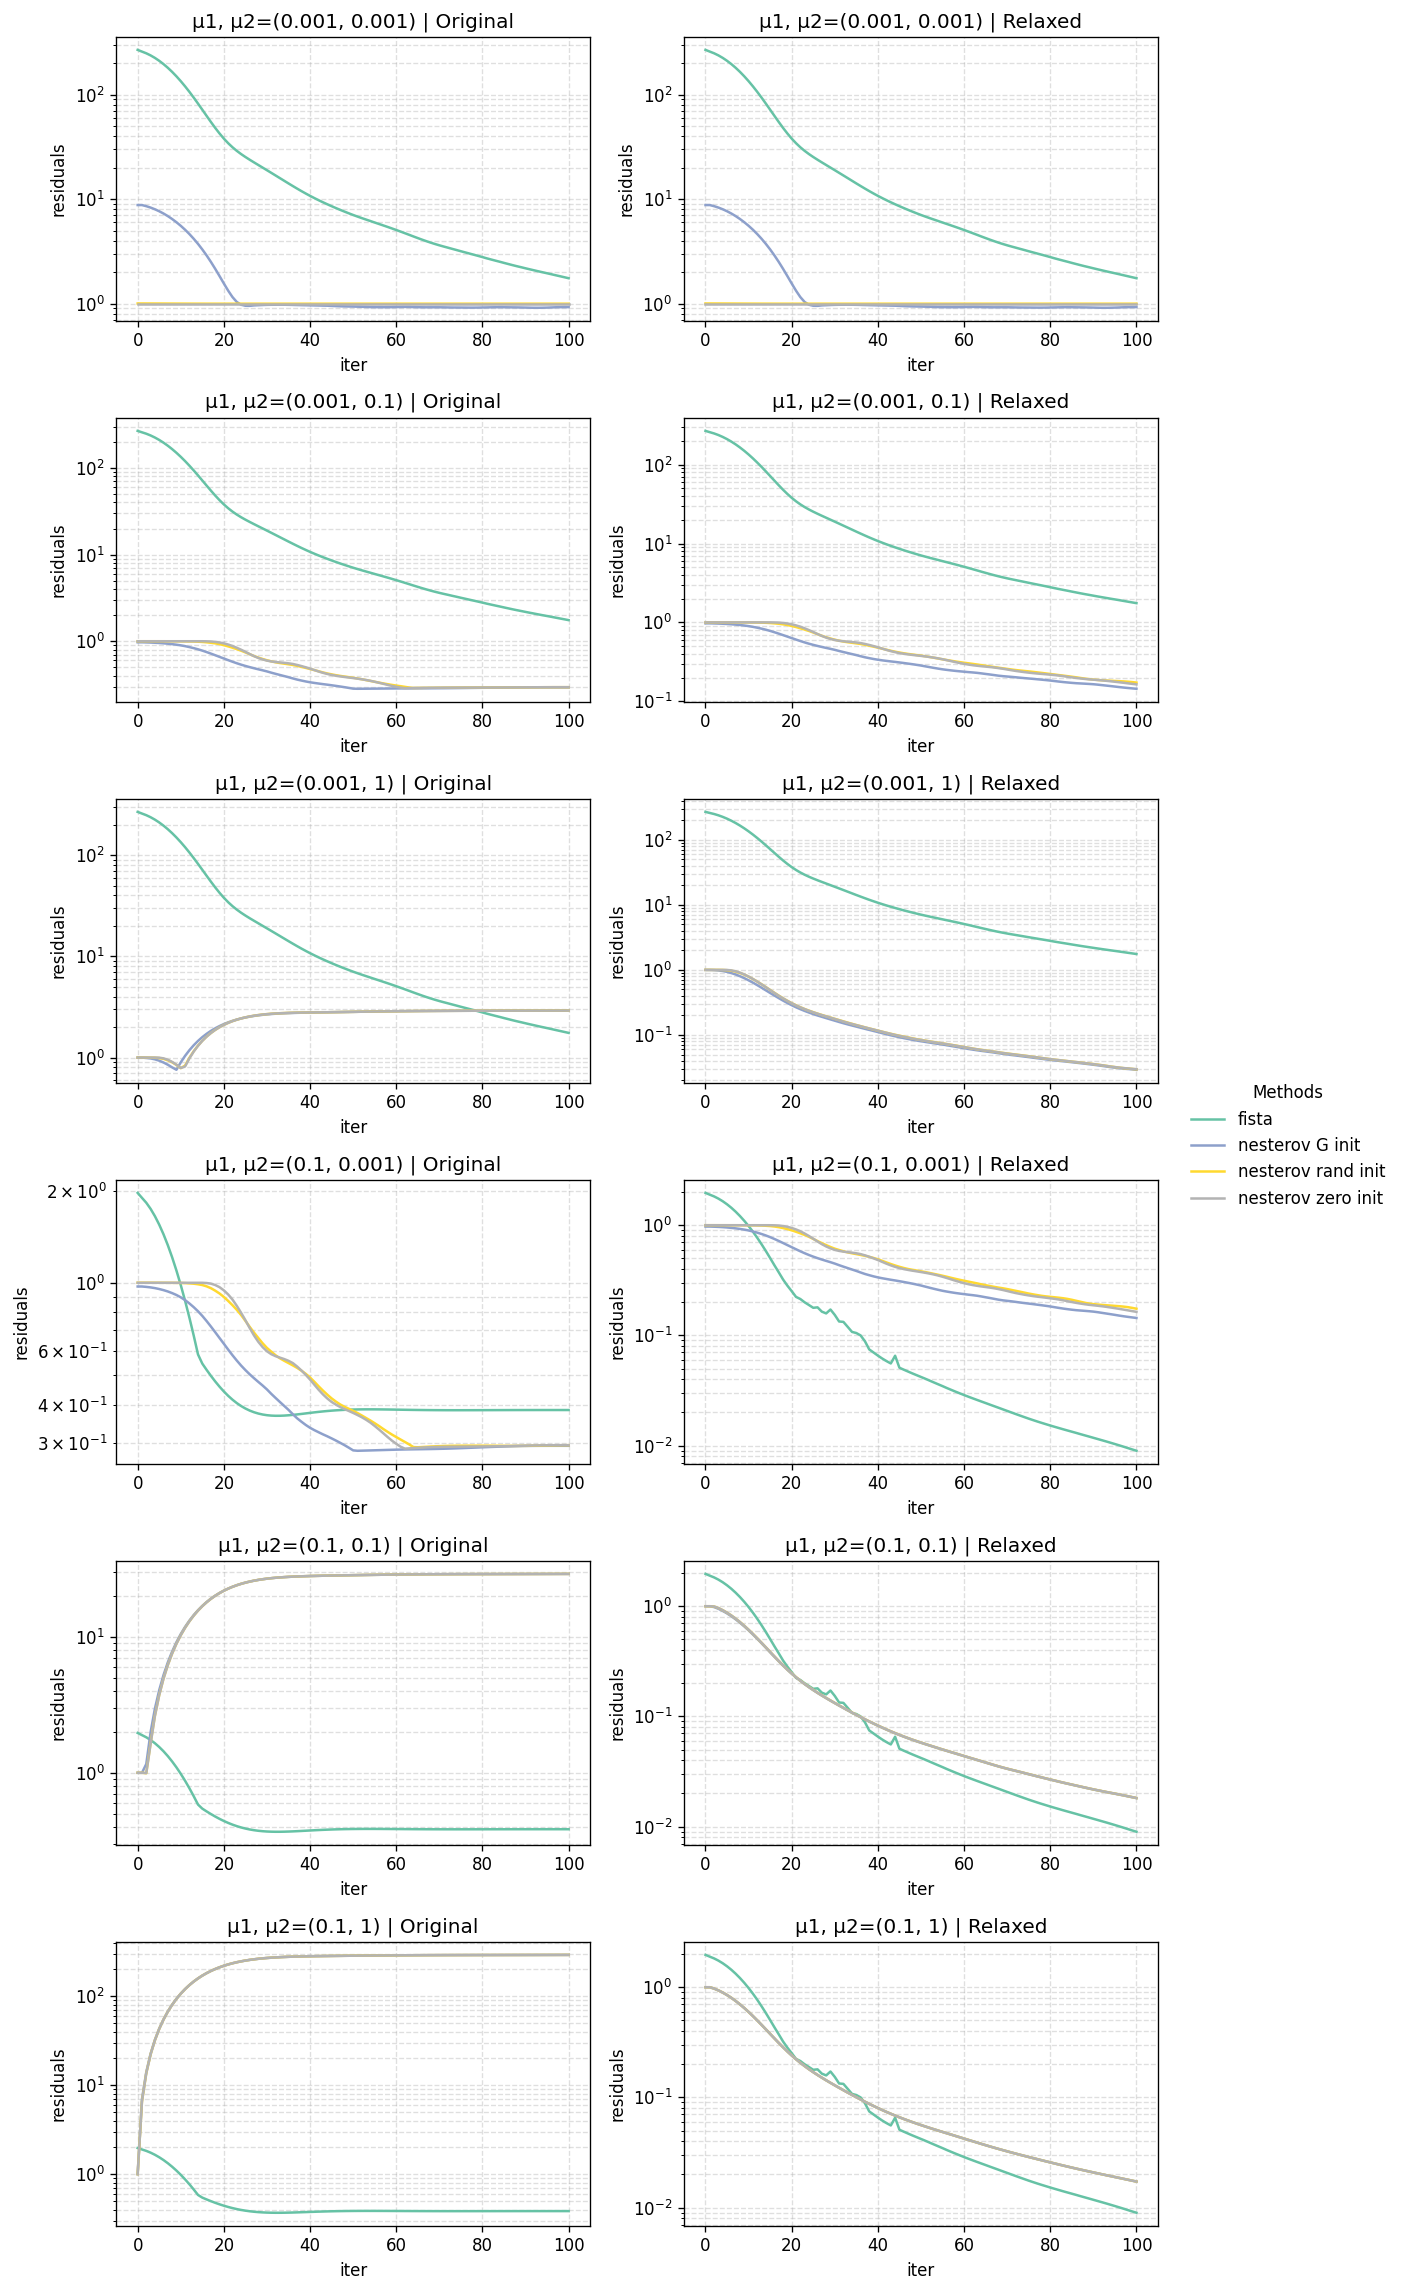

In [10]:
_ = plot_residuals_grid_by_param_appprox_vs_true(residuals)

#  $m=n=1000$

In [11]:
m = n = 1000
std2 = 0.1
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                        rank_ratio=rank_ratio, G_in_range=True)

mu_max = (G1.t() @ B + A.t() @ G2).abs().max().item() / beta
mu_reg = max(mu_scale * mu_max, 1e-6)
nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5 
print(f"{mu_reg=:.4e}, {lamb_max=:.4e}, {mu_max=:.4e}")

mu_reg=1.4071e-01, lamb_max=1.4152e+03, mu_max=1.4071e+02


In [12]:
residuals = {}
for mu_scale in mu_scales:
    for mu_mor_scale in mu_moreau_scales:
        mu_reg = max(mu_scale * mu_max, 1e-6)
        print(f"{mu_reg=:.4e}, {mu_scale=:.4e}, {mu_mor_scale=:.4e}")
        mu_moreau = max(mu_mor_scale * mu_reg, 1e-6)
        residuals[(mu_scale, mu_mor_scale)] = compare_methods_fista_nesterov(A, B, G1, G2, beta, mu_reg=mu_reg, mu_moreau=mu_moreau,
                                stopping=False, max_iter=max_iter)

mu_reg=1.4071e+01, mu_scale=1.0000e-01, mu_mor_scale=1.0000e+00
Method                 Obj          Viol
----------------------------------------
fista         -8.958194e-01  1.049634e+00
nesterov G init  -6.087744e-01  9.098749e-01
nesterov rand init  -2.896109e-01  5.886839e-01
nesterov zero init  -2.898414e-01  2.891446e-01
mu_reg=1.4071e+01, mu_scale=1.0000e-01, mu_mor_scale=1.0000e-01
Method                 Obj          Viol
----------------------------------------
fista         -8.958194e-01  1.049634e+00
nesterov G init  -3.663625e-01  1.741214e-01
nesterov rand init  -2.911364e-02  5.014239e-02
nesterov zero init  -2.898433e-02  0.000000e+00
mu_reg=1.4071e+01, mu_scale=1.0000e-01, mu_mor_scale=1.0000e-03
Method                 Obj          Viol
----------------------------------------
fista         -8.958194e-01  1.049634e+00
nesterov G init  -3.382097e-01  9.129259e-02
nesterov rand init  -2.019020e-04  2.388281e-02
nesterov zero init  -2.898433e-04  0.000000e+00
mu_reg=1.4071

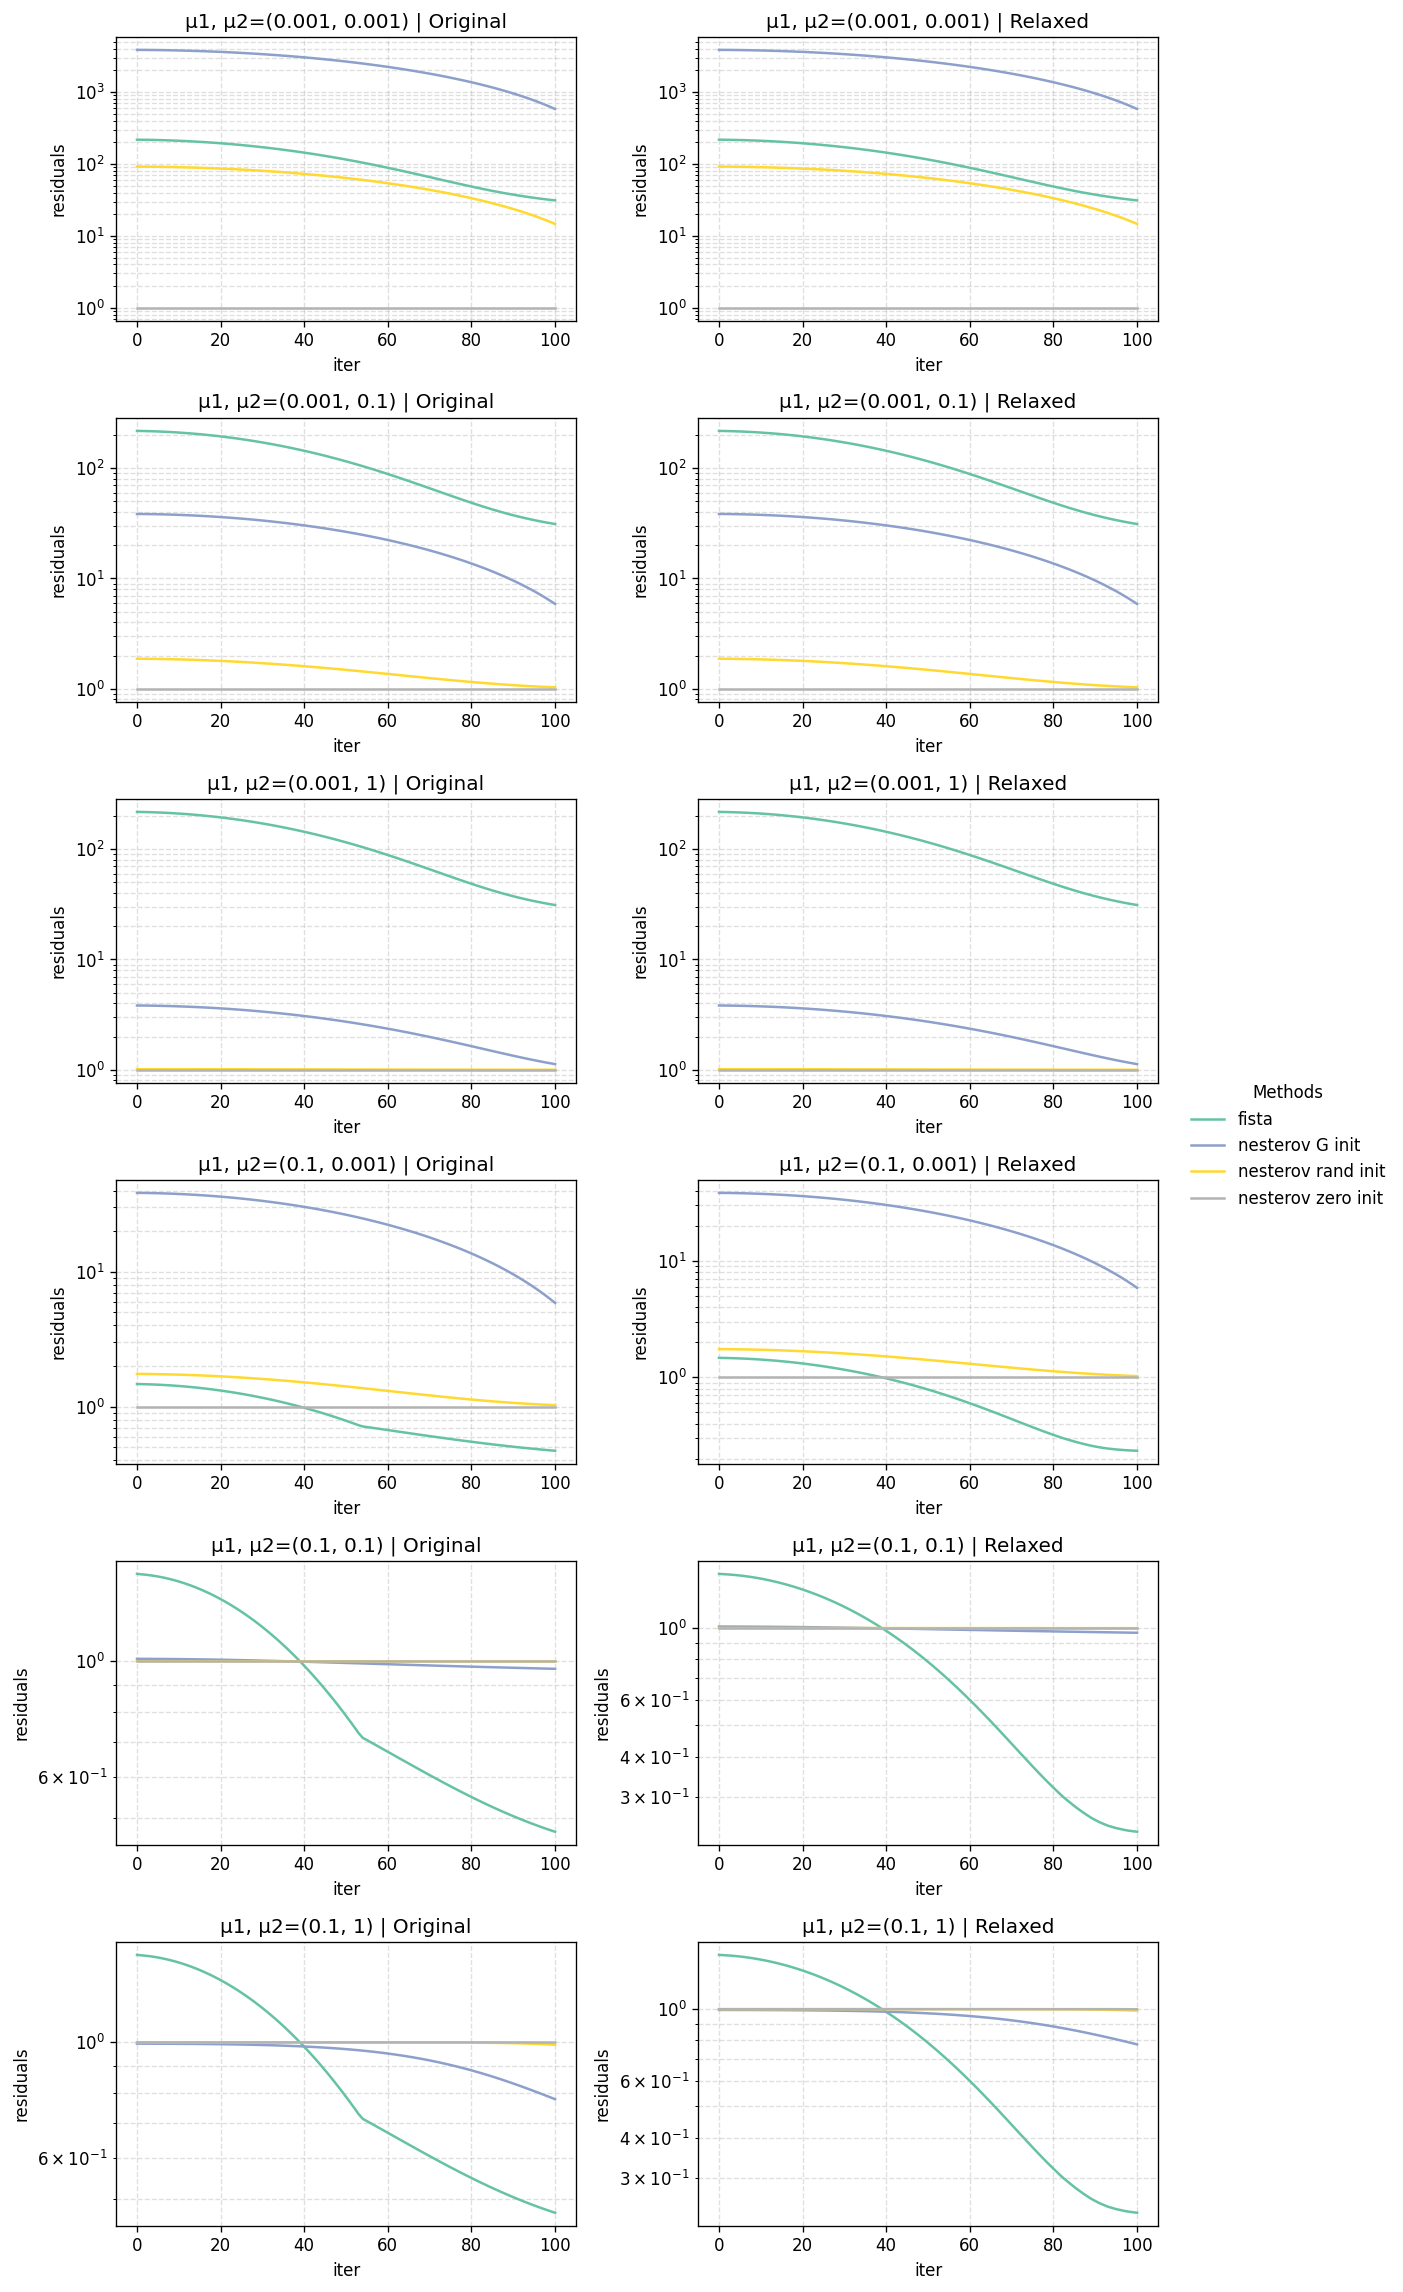

In [13]:
_ = plot_residuals_grid_by_param_appprox_vs_true(residuals)